# 뉴럴 스타일 변환

Neural Style transfer는 Deep Dream과 마찬가지로 CNN 필터를 이용한 Image modification 기술이다. 

아래는 Neural Style transfer가 최소화 하려는 목적 함수이다. 
$$
\begin{eqnarray}
Loss(image \ to \ transfer) 
&=& distance(style(reference \ image) - style(generated \ image)) \\
&+&
distance(content(original \ image) - content(generated \ image))
\end{eqnarray}
$$

Loss함수는 3가지 파트로 나뉜다. 

1. Content loss 
: Content Loss는 원본 이미지가 가지고 있는 전체적인 시각적인 패턴을 유지하는 기능을 수행한다. CNN에서는 layer를 거쳐가면서, 점차 높은 수준의 특징을 추출한다. 첫 layer에서는 Edge 성분 같은 비교적 단순한 특징을 찾고, 마지막 Convolutional Layer에서는 이미지에서 사물의 형태 같이 복잡한 특징을 추출한다. 그래서 Content Loss에서 사용하는 것은 뒷 단의 Layer 하나의 출력값을 사용한다. 
    -  Content loss : 원본 이미지와 생성한 이미지를 CNN에 통과 시키고, 같은 Layer의 출력값들의 차를 구하고, 그 차의 제곱합으로 정의한다. 
    
    <br>
    
2. Style loss
: 이미지의 Style은 광범위한 개념을 포괄한다. 이미지에서 보이는 색감, 질감, 형태 등등 여러가지 특징이 복합적으로 구성된 것이다. 그래서, Style Loss를 정의 할 때는, 여러 개의 Layer를 사용한다. 이 논문에서는 Gram Matrix라는 것을 만들어서 여러개의 Layer를 사용하는데, Gram Matrix는 각 Layer들의 출력값을 내적하여 만든 행렬을 의미한다. 이 행렬은 여러 Layer의 내적으로 만들어 진 것이기 때문에, 각 Layer들 간의 Correlation 정보를 가지고 있다. 이 Correlation의 정보가 이미지가 가지고 있는 복합적인 스타일을 표현한다. 결과적으로 Style Loss는 학습 간에, 각 Layer들의 Correlation을 최대한 보존하며 이미지가 변화하도록 하는 기능을 수행한다. 
    -  Style loss : style reference image의 여러 Layer의 출력값으로 만든 Gram Matrix에서 생성한 이미지의 같은 Layer들의 출력값으로 만든 Gram Matrix를 뺀 후, 그 결과 행렬의 $L2$ norm이라고 정의한다. 
    
    <br>

3. total variation loss
: total variation loss는 결과 이미지의 품질을 위한 부가적인 Loss 이다. 이미지는 인접한 위치에서 연속성이 보전되어야 하기 때문에, 픽셀 레벨에서 인접 픽셀 값들의 차이가 커지지 않도록 해주는 기능을 한다. 

#### 구현 

  1. ImageNet 데이터 셋에 대해 미리 훈련된 VGG19 모델을 사용한다. 
  
  2. 각 Loss 들을 정의 한다. 
  
  3. 이 Loss를 최소화 하기위한 Gradient descent 를 수행한다. 

부가적으로, 이미지 간의 크기가 크게 차이 나면, Style 변환이 잘 되지 않기 때문에, 이미지의 크기를 어느정도 맞추어 주는 것이 좋다. 

In [1]:
from keras.preprocessing.image import load_img, img_to_array, save_img
from keras.applications import vgg19
from keras import backend as K
import tensorflow as tf
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt 
import time 
from sklearn.datasets import load_sample_image
from imageio import imread 
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# 사용 할 이미지 
target_img = load_sample_image('china.jpg')
reference_img = imread('imageio:hubble_deep_field.png')

height, width = target_img.shape[:-1]

img_height = 400
img_width = int(width * img_height / height)

Using TensorFlow backend.


In [2]:
# 이미지 처리 함수
def preprocess_image(img):
    img = sp.misc.imresize(img, (img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img 

def deprocess_image(x):
    
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    x = x[:, :, ::-1] # BGR to RGB
    x = np.clip(x, 0, 255).astype('uint8')
    return x 

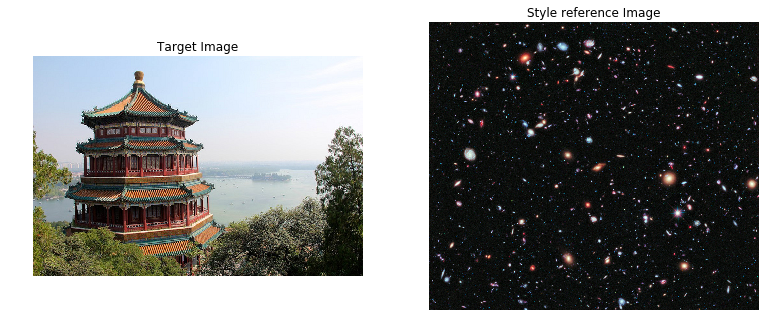

In [3]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 13))

ax1.imshow(target_img)
ax1.set_axis_off()
ax1.set_title("Target Image")

ax2.imshow(reference_img)
ax2.set_axis_off()
ax2.set_title("Style reference Image")
plt.show()

In [4]:
# Loss 함수 정의
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3 
    size = img_height * img_width
    
    return K.sum(K.square(S - C)) / (4. * (channels**2) * (size**2))

def total_variation_loss(x) :
    
    # y축으로의 변화
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    
    # x축으로의 변화 
    b = K.square(
        x[:, :img_height - 1, :img_width -1, :] - x[:, :img_height - 1, 1:, :])
    
    return K.sum(K.pow(a + b, 1.25))

# content Loss에 사용되는 Layer
content_layer = 'block5_conv2'

# Style Loss에 사용되는  Layer
style_layers = ['block1_conv1', 
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# 각 Loss들의 가중치 
total_variation_weight = 1e-4
style_weight = 1.5
content_weight = 0.25

In [5]:
with tf.Session() as sess:

    target_image = K.constant(preprocess_image(target_img))
    style_reference_image = K.constant(preprocess_image(reference_img))
    
    combination_image = K.placeholder((1, img_height, img_width, 3))

    input_tensor = K.concatenate([target_image, 
                                 style_reference_image,
                                 combination_image], axis=0)

    model = vgg19.VGG19(input_tensor=input_tensor,
                       weights='imagenet', include_top=False)

    loss = K.variable(0.) 

    layer_features = model.get_layer(content_layer).output
    target_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = loss + content_weight * content_loss(target_image_features, combination_features)

    for layer_name in style_layers:
        layer_features = model.get_layer(layer_name).output
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        s1 = style_loss(style_reference_features, combination_features)
        loss = loss + (style_weight / len(style_layers)) * s1

    loss = loss + total_variation_weight * total_variation_loss(combination_image)

    grads = K.gradients(loss, combination_image)[0]

    fetch_loss_and_grads = K.function([combination_image], [loss, grads])

    class Evaluator(object):

        def __init__(self):
            self.loss_value = None
            self.grads_values = None

        def loss(self, x):
            assert self.loss_value is None
            x = x.reshape((1, img_height, img_width, 3))
            outs = fetch_loss_and_grads([x])
            loss_value = outs[0]
            grad_values = outs[1].flatten().astype("float64")
            self.loss_value = loss_value
            self.grads_values = grad_values
            return self.loss_value

        def grads(self, x):
            assert self.loss_value is not None 

            grad_values = np.copy(self.grads_values)
            self.loss_value = None
            self.grad_values = None 
            
            return grad_values

    evaluator = Evaluator()


    result_prefix = 'result_of_NST'
    iterations = 20 

    x = preprocess_image(target_img)

    x = x.flatten()
    for i in range(iterations):
        start_time = time.time()
        x, min_val, info = sp.optimize.fmin_l_bfgs_b(evaluator.loss,
                                        x,
                                        fprime=evaluator.grads,
                                        maxfun=20)

        print("iter : {}, Loss : {}".format(i ,min_val))
        img = x.copy().reshape((img_height, img_width, 3))
        img = deprocess_image(img)
        end_time = time.time()
        print('Iter : {} completed in {}'.format(i, round(end_time - start_time, 2)))
    
    fname = result_prefix + '.jpeg' 
    save_img(fname, img)
    print('image saved as {}'.format(fname))

iter : 0, Loss : 13081273344.0
Iter : 0 completed in 6.29
iter : 1, Loss : 5606162432.0
Iter : 1 completed in 3.52
iter : 2, Loss : 3448719616.0
Iter : 2 completed in 3.61
iter : 3, Loss : 2673054720.0
Iter : 3 completed in 3.62
iter : 4, Loss : 2207742720.0
Iter : 4 completed in 3.88
iter : 5, Loss : 1940343168.0
Iter : 5 completed in 3.8
iter : 6, Loss : 1764228992.0
Iter : 6 completed in 3.78
iter : 7, Loss : 1631960576.0
Iter : 7 completed in 3.66
iter : 8, Loss : 1539109120.0
Iter : 8 completed in 3.61
iter : 9, Loss : 1465475328.0
Iter : 9 completed in 3.62
iter : 10, Loss : 1388811520.0
Iter : 10 completed in 3.68
iter : 11, Loss : 1325813504.0
Iter : 11 completed in 3.7
iter : 12, Loss : 1274868224.0
Iter : 12 completed in 3.68
iter : 13, Loss : 1235376896.0
Iter : 13 completed in 3.63
iter : 14, Loss : 1199494144.0
Iter : 14 completed in 3.66
iter : 15, Loss : 1166045312.0
Iter : 15 completed in 3.75
iter : 16, Loss : 1135937536.0
Iter : 16 completed in 3.67
iter : 17, Loss : 

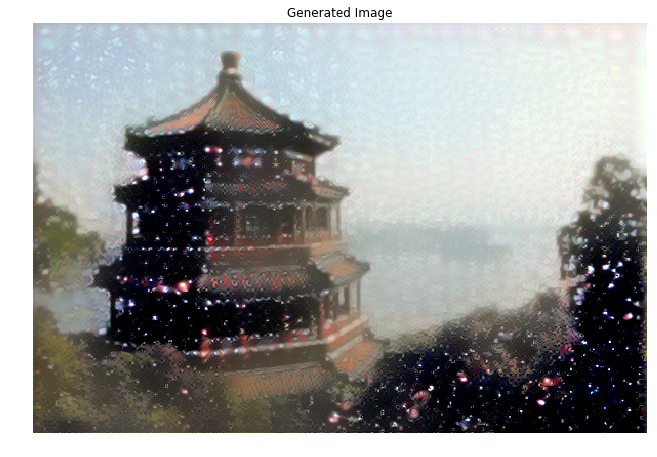

In [6]:
plt.figure(figsize=(11, 11))
plt.imshow(img)
plt.axis("off")
plt.title("Generated Image")
plt.show()